<a href="https://colab.research.google.com/github/vischia/adfm_2024-2025/blob/master/practice_2_a_parameterized_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Datos en Física Moderna

(C)2025 Pietro Vischia, vischia@uniovi.es

## PL 2: machine learning paramétrico

In this practice, you'll implement the parameterized machine learning algorithm devised by Baldi et al., [1601.07913](https://arxiv.org/abs/1601.07913)

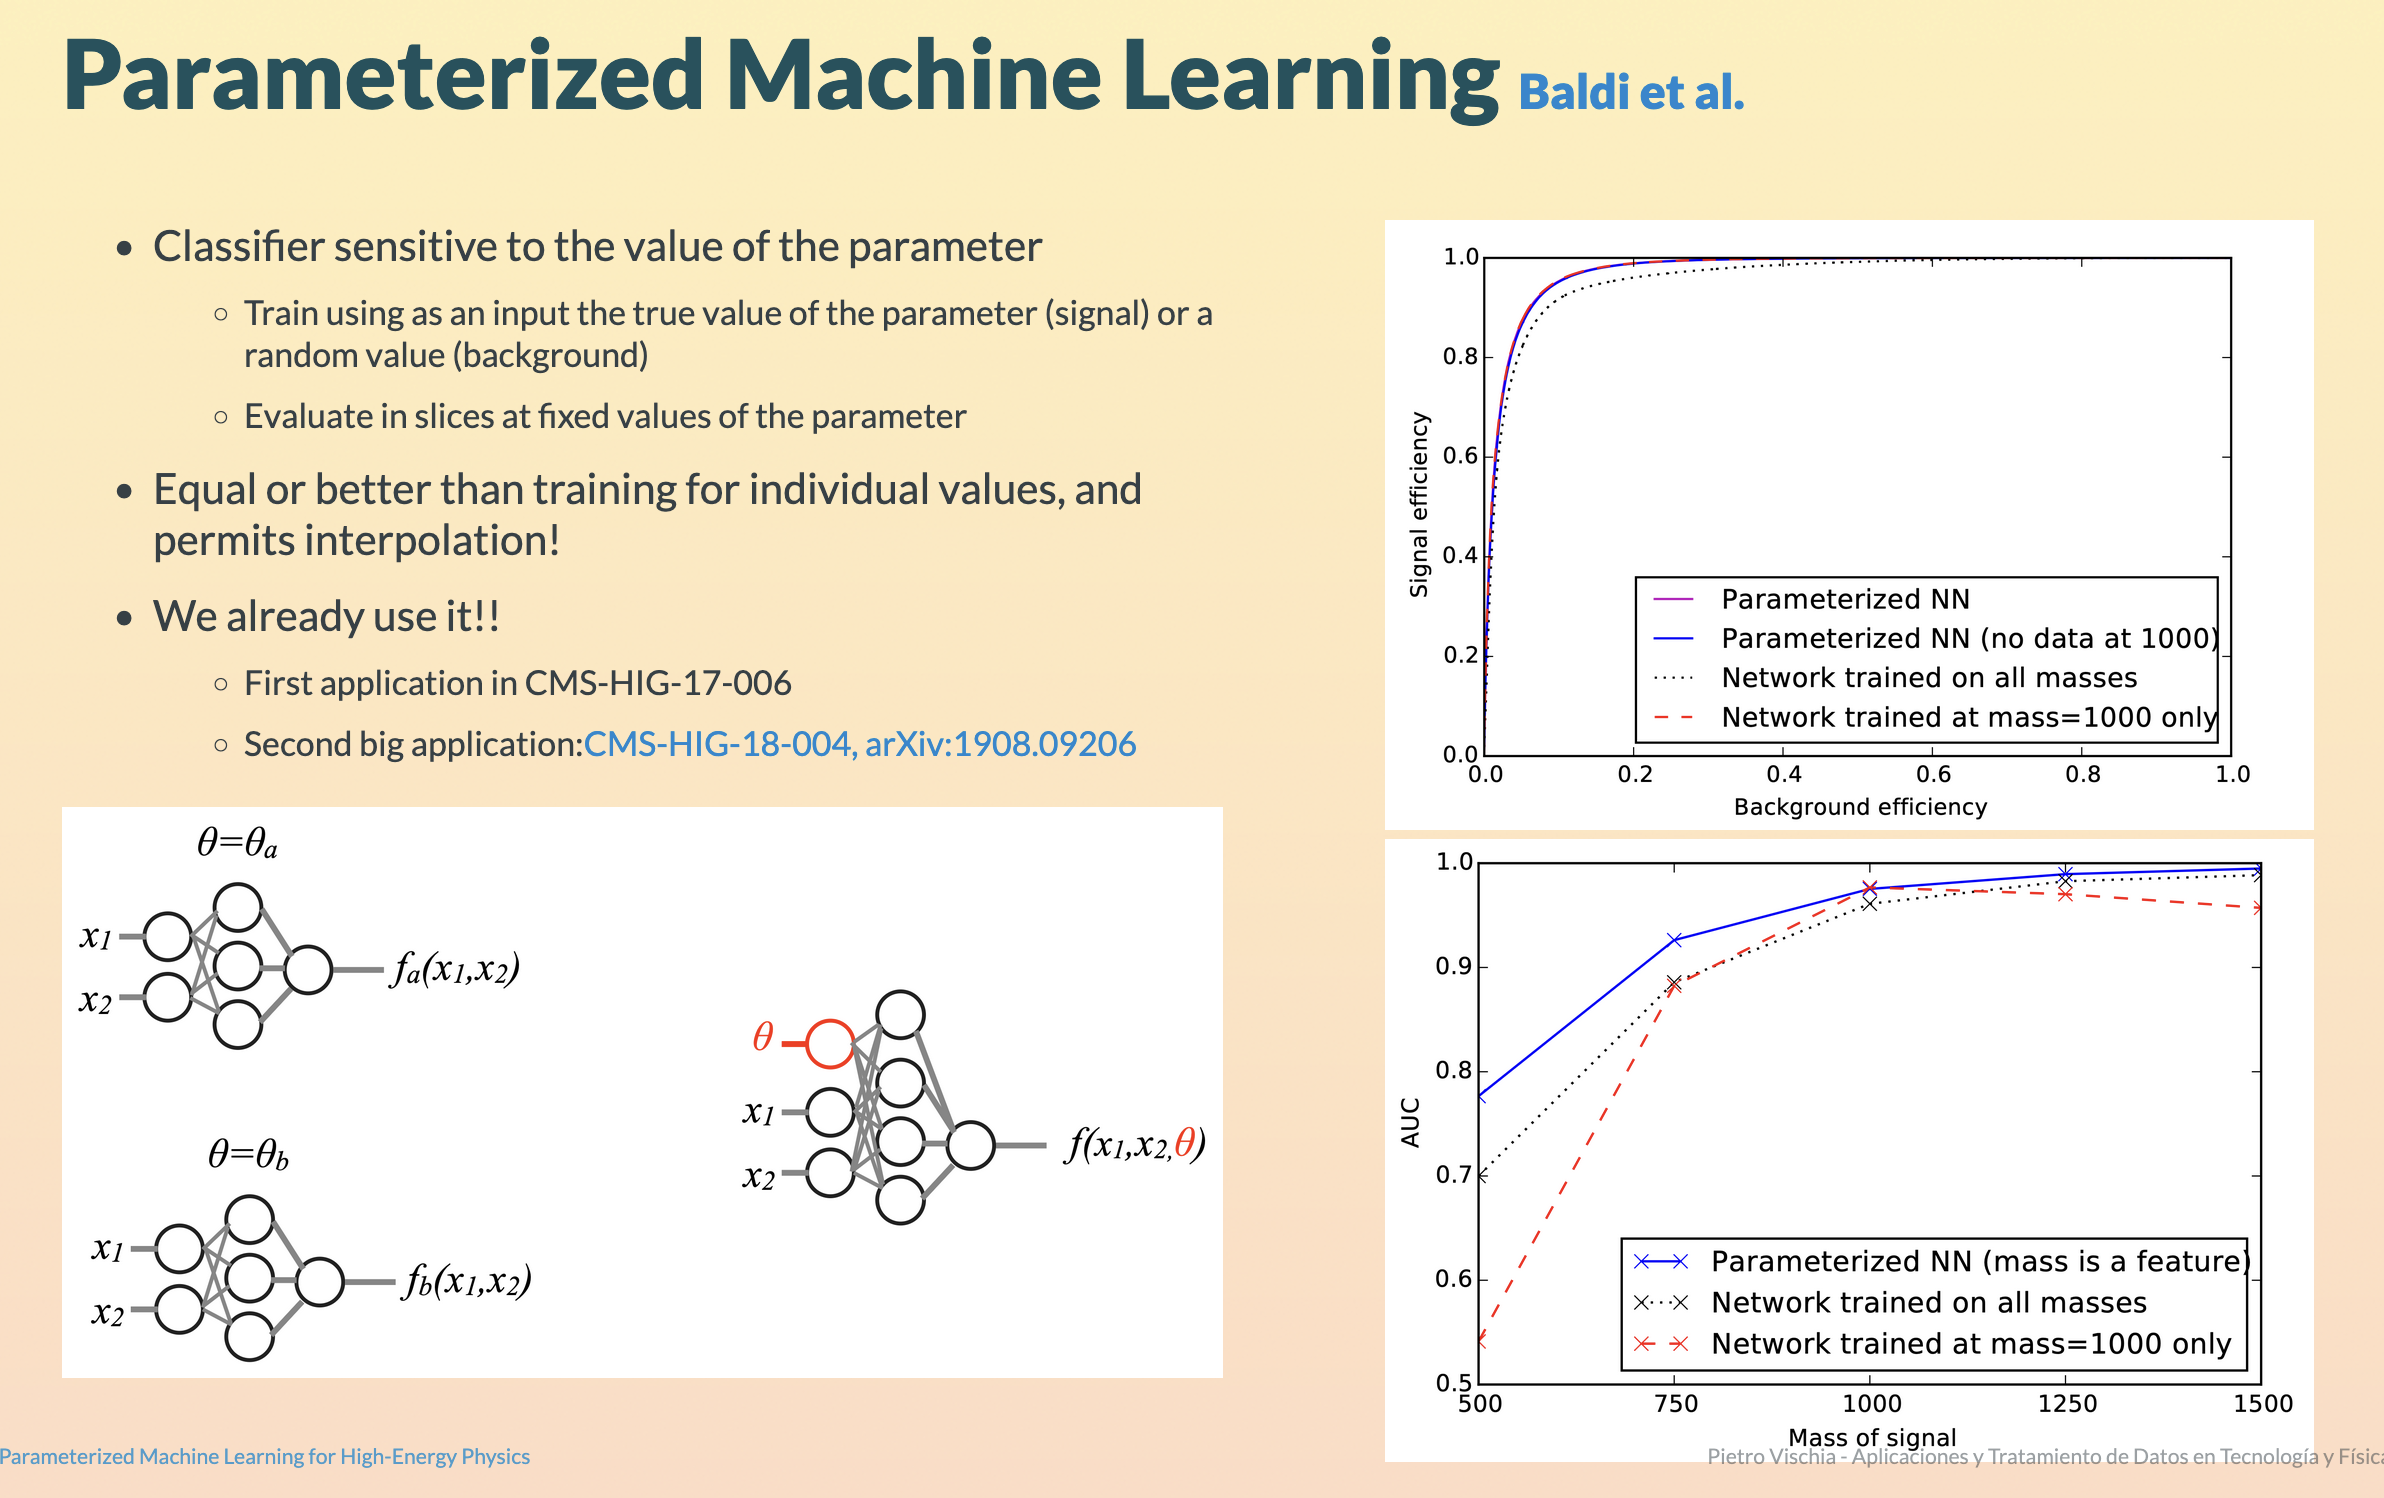

In [ ]:
# Uncomment and run this if you are running on Colab (remove only the "#", keep the "!").
# You can run it anyway, but it will do nothing if you have already installed all dependencies
# (and it will take some time to tell you it is not gonna do anything)


from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/"
! git clone https://github.com/vischia/atdtf.git
%cd atdtf
!pwd
!ls
!pip install livelossplot shap

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc

from scipy.optimize import newton
from scipy.stats import norm

import datetime
from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing
    
from livelossplot import PlotLossesKeras

import torch

import pandas as pd


In [ ]:
INPUT_FOLDER = './'
HAVE_GPU = True


We will use the [HEP-mass dataset](http://archive.ics.uci.edu/ml/datasets/hepmass) hosted by UCIrvine together with many other datasets used to test machine learning applications.

This dataset provides top pair production events as a background, and the classification task is to separate them from events generated by a high-mass resonance (masses of 500--1000 GeV). The larger the mass, the easiest the prediction task.

The label is 1 for signal, and 0 for background. There are 27 normalized features, divided into 22 low-level ones and 5 high-level ones. Because of time constraints, we won't explore the topic of pitting low-level and high-level features against each other or of mixing them, but you are encouraged to play with them later.

<img src="figs/hepmass.png" alt="masses from 1601.07913" style="width:50%;"/>

(figure from [1601.07913](https://arxiv.org/abs/1601.07913))

You can download the data from:

[https://www.hep.uniovi.es/vischia/adfm/](https://www.hep.uniovi.es/vischia/adfm/)

by hand or by running:

In [4]:
downloadMinidata=False

if downloadMinidata:
    !mkdir data
    !cd data
    !wget https://www.hep.uniovi.es/vischia/adfm/data_for_practica2.zip
    !unzip data_for_practica2.zip
    !cd ..

In [ ]:
# Do not set these to True in the live tutorial, 
# otherwise you will clog the conference venue connection for nothing.
# The skimmed files are already included in this repository

createLowMass=False
createHighMass=False

if createLowMass:
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/not1000_train.csv.gz
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/not1000_test.csv.gz
    cols=["label", "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13",
          "14f", "15f", "f16", "f17", "f18", "f19", "f20", "f21", "f22", "f23", "f24", "f25", "f26", "mass"]
    
    train_set = pd.read_csv('./not1000_train.csv.gz', index_col=False, names=cols, header=0)
    test_set = pd.read_csv('./not1000_test.csv.gz', index_col=False, names=cols, header=0)

    # Here we exploit the fact that the background has an assigned random mass sampled from
    # the same set than that of the signal. Therefore we can just require the mass to be 500
    # without having to check for the signal and background label.
    # A final test ensures the amount of events is approximately the same.
    
    # In the data set, for some reason the "mass 500" is encoded as 499.999969, but "==499.999969" does not
    # match any entry. We will therefore use "<501" to select the events with mass=500

    train_set=train_set[train_set['mass']<501]
    test_set=test_set[test_set['mass']<501]

    print('Full train', len(train_set),
          len(train_set[train_set['label']==1]),
          len(train_set[train_set['label']==0]))
    print('Full test', len(test_set),
          len(test_set[test_set['label']==1]),
          len(test_set[test_set['label']==0]))

    train_set_temp=train_set.head(10000)
    test_set_temp=test_set.head(10000)

    train_set_temp.to_csv('data/not1000_train_medium.csv')
    test_set_temp.to_csv('data/not1000_test_medium.csv')


    train_set_temp=train_set.head(1000)
    test_set_temp=test_set.head(1000)

    train_set_temp.to_csv('data/not1000_train_small.csv')
    test_set_temp.to_csv('data/not1000_test_small.csv')


if createHighMass: # Not needed, I included the small and medium sets in the github repository
    
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/1000_train.csv.gz
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/00347/1000_test.csv.gz
    # This needs to be run only once
    cols=[label_name, "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13", "14f", "15f", "f16", "f17", "f18", "f19", "f20", "f21", "f22", "f23", "f24", "f25", "f26"]
    train_set = pd.read_csv('./1000_train.csv.gz', index_col=False, names=cols, header=0)
    test_set = pd.read_csv('./1000_test.csv.gz', index_col=False, names=cols, header=0)

    # Randomly pick 10000 events from the full data set
    train_set_temp=train_set.head(10000)
    test_set_temp=test_set.head(10000)

    train_set_temp.to_csv('data/1000_train_medium.csv')  
    test_set_temp.to_csv('data/1000_test_medium.csv')
    
    # Randomly pick 1000 events from the full data set
    train_set_temp=train_set.head(1000)
    test_set_temp=test_set.head(1000)

    train_set_temp.to_csv('data/1000_train_small.csv')  
    test_set_temp.to_csv('data/1000_test_small.csv')


In [ ]:
# Load the chosen set
train_set=pd.read_csv('data/not1000_750_train_medium.csv', index_col=False)
test_set=pd.read_csv('data/not1000_750_test_medium.csv', index_col=False)

# Drop mass info, if needed (the "1000..." files don't have a 'mass' column)
if 'mass' in train_set.columns:
    train_set=train_set.drop(['mass'], axis=1)
    test_set=test_set.drop(['mass'], axis=1)
train_set.head()

In [ ]:
print('Training set has', len(train_set), 'entries (', len(train_set[train_set['label']==1]), 'signal entries, ',
      len(train_set[train_set['label']==0]), ' background entries)')

### Split the data set into training and test set

When we train a machine learning algorithm, we are trying to solve an interpolation problem (*find the function of the input features that provides the best approximation of the true function*) by also requiring that the solution generalizes sufficiently well (*the interpolating function must also predict correctly the value of the true function for new, unseen data*).


When we have a labelled dataset, we will therefore split it into: a *training set*, which we will use to train the machine learning algorithm; a *test set*, which we will use to evaluate the performance of the algorithm for various realizations of the algorithm (e.g. tuning hyperparameters); and an *application set*, which are the data we are really interested in studying in the end.

For many applications, when the amount of hyperparameters tuning is moderate, application set and test set can be collapsed into a single set (usually called *test set*). This is what we will do in this tutorial.

![Blah](figs/trainingNetwork.png)

(Image: P. Vischia, [doi:10.5281/zenodo.6373442](https://doi.org/10.5281/zenodo.6373442))

For the data set that we have loaded, we don't need to do any splitting, because the data set is already split. 
If our data set needed to be split, we would do something like



In [ ]:
# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)


### Inspect the data set

The first and most important thing to do, when developing a ML application, is to inspect the data set.

Looking at the data is crucial, because it may reveal the presence of malformed or missing data (e.g. when one feature has been filled with meaningless values for some or all of the data points) and may hint at whether it is necessary to preprocess the data.

In [ ]:
# Visualize dataset

import seaborn as sns
sns.set()

In [ ]:
print(sns.__version__)

cols_to_plot = train_set.columns[1:6].tolist()

pp=sns.pairplot(data=train_set.sample(100)[cols_to_plot], hue='label', diag_kws={'bw': 0.2})
#sns.pairplot(train_set.sample(100))
plt.show()

In [ ]:
pp.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show(sns)

#### Correlation matrices

Take a look at the correlation matrices

In [ ]:
def corrmatrix(corr, label):
    ax = sns.heatmap(
        corr, 
        vmin=-1., vmax=1., center=0.,
        cmap=sns.diverging_palette(20., 220., n=200, as_cmap=True),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

    ax.set_title('Correlation matrix for %s events' % label)

    plt.show()


corrmatrix(train_set[train_set['label']==1.].corr(), 'signal')
corrmatrix(train_set[train_set['label']==0.].corr(), 'background')


### Preprocess the data

Normally you'd check if it makes sense to preprocess the input features.

Unfortunately, **the HEPmass dataset contains pre-normalized features, so it doesn't make sense to renormalize them**.
You are welcome to check the effect of scalers on other datasets. For reference, you can check [this `scikit-learn` post](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) for the python code to apply scalers to input features.

#### Build a parametric neural network

Following the instructions below

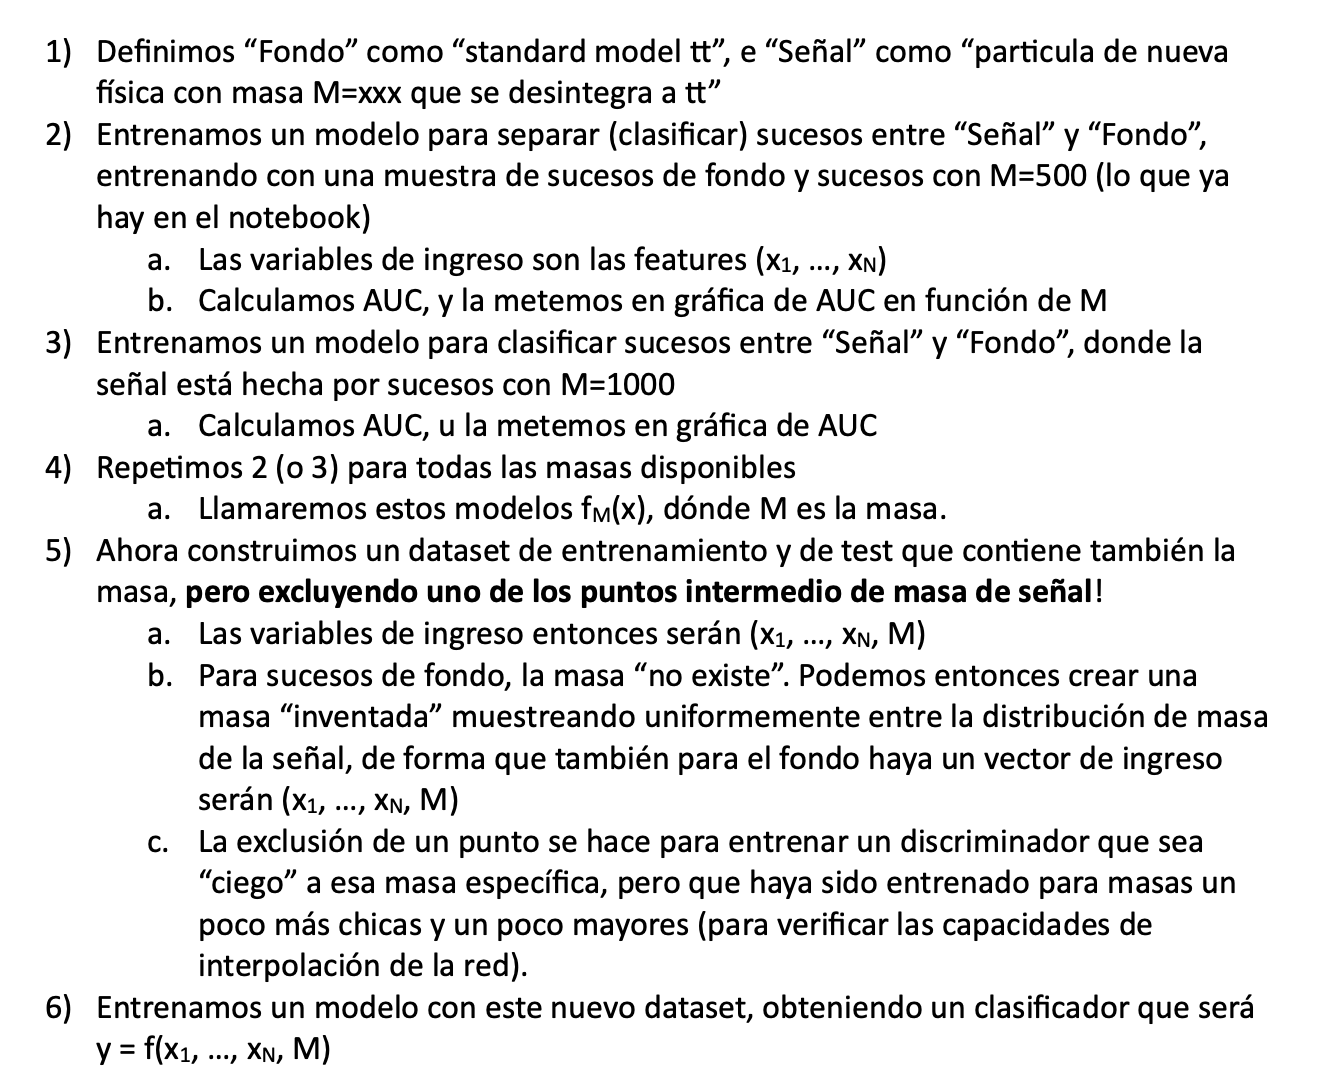
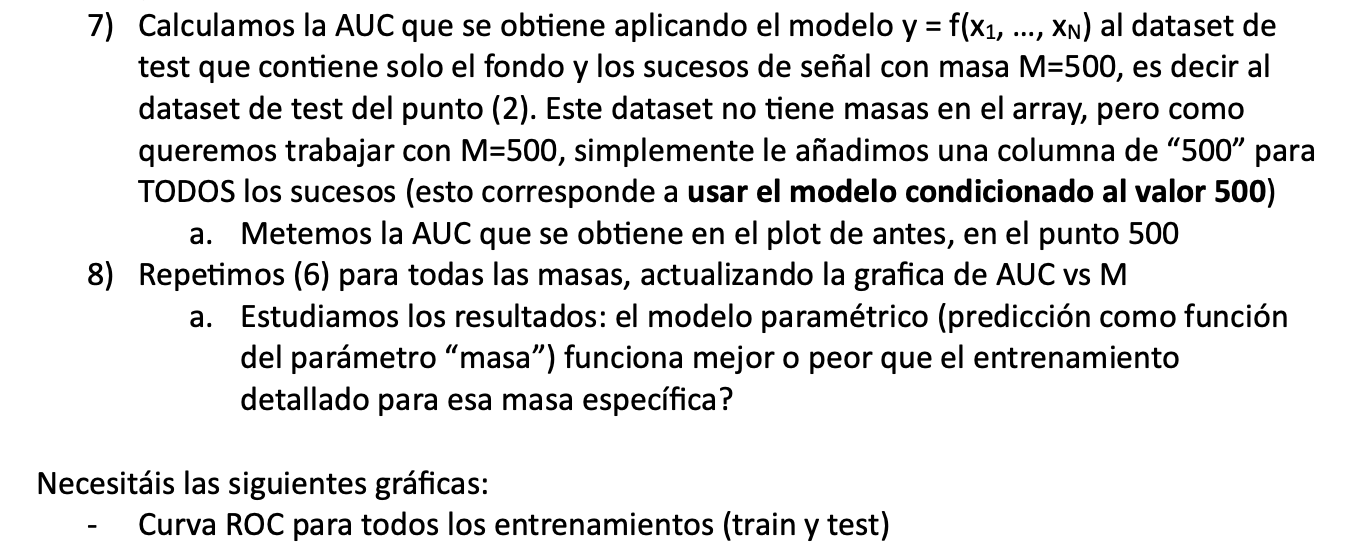
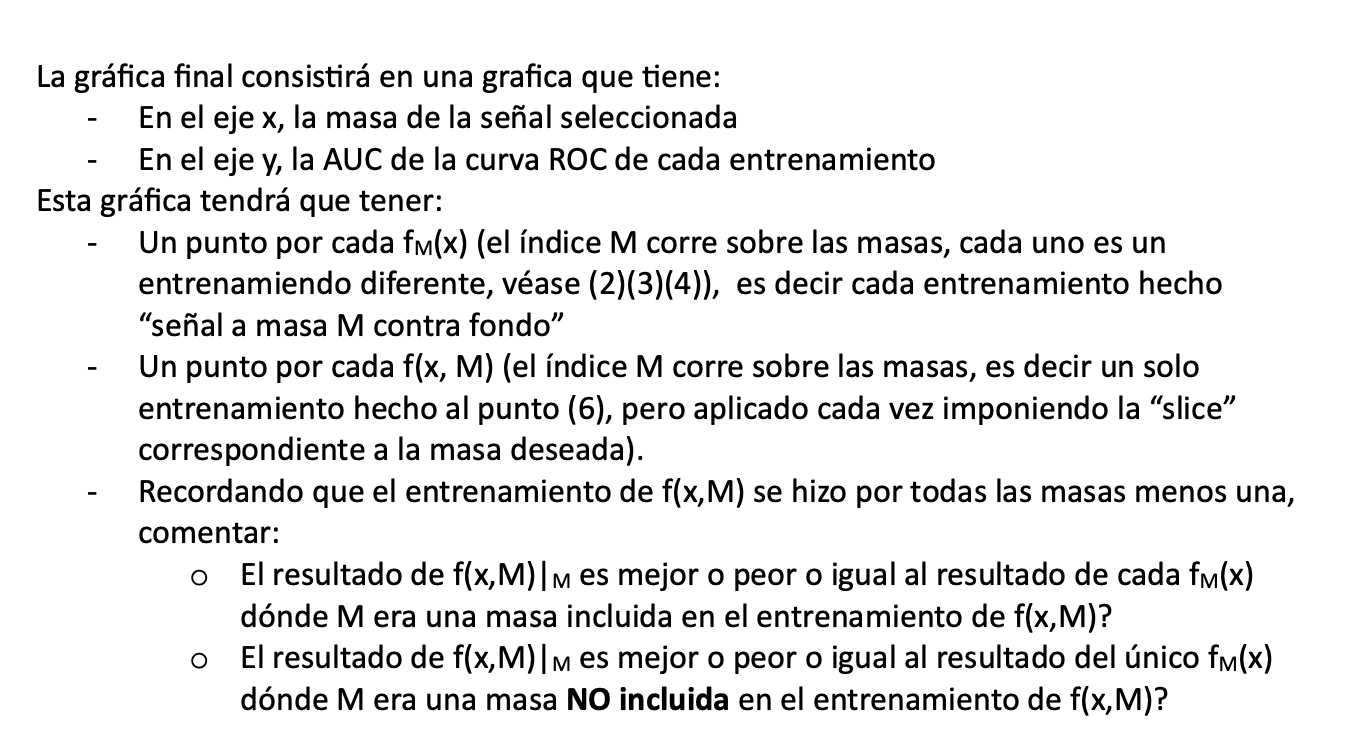